In [783]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import random
from itertools import product
import itertools
from collections import Counter
from functools import reduce
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [11]:
colours = 8
places = 5
init_set = list(product(list(range(colours)),repeat = places))

In [1060]:
# helper functions

#returns the zero colours from a set list
def zero_colors(colour_list, set_list):
    res = []
    for col in colour_list:
        if col not in set_list:
            res.append(col)
    return res

def init_set(colour_list, places):
    return  np.array(list(product(colour_list, repeat = places)))

def set_aft_resp(guess, response, set_list):
    responses = resp_list(guess, set_list)
    #expected result
    xptd_rep = np.repeat([response], len(responses), axis=0)
    # test equality, sum on axis, if == 2 exactcly the same then gets the arguments
    equality = (responses == xptd_rep)
    s = np.sum(equality, axis=1) 
    args = (s == 2)
    return set_list[args]

def response(code, guess):
    black = white = 0
    code_t = list(code)
    guess_t = list(guess)
    for i in range(len(code)):
        if code_t[i] == guess_t[i]:
            black += 1
            code_t[i] = -1
            guess_t[i] = -1
    for i in range(len(code)):
        if guess_t[i] != -1:
            if guess_t[i] in code_t:
                code_t[code_t.index(guess_t[i])] = -1
                white += 1
    return (black, white)

    
def entropy(guess, code_set):
    results = resp_list(guess, code_set)
    distrib = np.array(list(Counter(results).values()))
    disp= distrib/sum(distrib)
    return -sum(np.log(disp)*disp)

# returns a try set with duplicate on free colors removed
def free_set(free_colors, set_list):
    if len(free_colors) <= 1:
        return set_list
    else:
        res_list = []
        for g in set_list: 
            g_res = []
            hash_res = {}
            nb_fc = 0
            for c in g:               
                if c in free_colors:
                    if c not in hash_res.keys():
                        nb_fc += 1
                        hash_res[c] = - nb_fc
                    g_res.append(hash_res[c])
                    
                else:
                    g_res.append(c)
            res_list.append(str(g_res).strip('[]'))
    #print("reslist:", res_list[:20])
    # keep unique values
    res_set = set(res_list)
    # str to list 
    res_arr = np.array([[int(e) for e in s.split(',')] for s in res_set])
    print("res_arr:", res_arr[:20])
    for i, col in enumerate(free_colors):
        print("set ", i, " with ", col)
        res_arr[res_arr == -(i+1)] = col
    return res_arr
                

In [999]:
def first_true(arr, axis, invalid_val=-1):
    mask = arr==True
    return np.where(mask.any(axis=axis), mask.argmax(axis=axis), invalid_val)

def resp_list(guess, code_set):
    sets = code_set# np.array
    codes = np.repeat([guess], len(code_set), axis = 0)
    eq = np.equal(codes,sets)
    eq2 = np.copy(eq)
    blacks = eq.sum(axis=1) 

    codes_ma = ma.array(codes, mask = eq)
    codes_wh = codes_ma.T
    sets_ma = ma.array(sets, mask = eq2)
    whites = np.zeros(len(codes.T[0]), int)
   # print(sets_ma)
   # print(codes_ma)
    for i in range(len(codes_wh.T[0])):
        #print("Test %d columns %s" %(i,sets[:,i]))
        #print("sets", sets)
        columns = ma.repeat([sets_ma[:,i]], sets.shape[1], axis = 0)
        res = np.equal(columns, codes_wh)
        su = res.sum(axis = 0)
        #print("res   \n", res.T)
        bo = su > 0
        whites = whites + np.array(bo).astype(int)
       # print("whites", whites)
        ft = first_true(res,0)
        #print("ft", ft)
        #print("codes\n", codes)
        arg_ok = np.argwhere(np.array(ft) != -1)[:,0]
        ft_idx = tuple([np.array(ft)[arg_ok], arg_ok]) 
        codes_wh[ft_idx] = ma.masked
        #for j in range(len(res.T)):
        #    if ft[j] != -1:
        #        codes_wh[ft[j],j] = ma.masked
        #print("codes\n", codes)
    return list(zip(blacks, whites))

resp_list(to_l("01230"), np.array([wrong_try]))

[(2, 0)]

In [954]:
class Game:
    def __init__(self, places=5, colors=8, code = ""):
        self.places = places
        self.colors = colors
        self.guess_list = list()
        self.resp_list = list()
        self.set_list = list()
        self.free_colors = list(range(colors))
        init_set = np.array(list(product(list(range(colors)), repeat = places)))
        self.set_list.append(init_set)
        self.cur_move = 0
        if code == "":
            self.code = [random.randint(0,colors-1) for _ in range(places)]
        else: 
            self.code = code
        print("Code : ", self.code)
        self.play_function = lambda x: [0,0,0,0,0]
    
    def get_free_colors(self, move):
        merge_l = list(itertools.chain.from_iterable(g.guess_list[:(g.cur_move)])) 
        self.free_colors = [col for col in list(range(self.colors)) if col not in merge_l]
        return self.free_colors
    
    def back(self):
        self.guess_list.pop()
        self.resp_list.pop()
        self.set_list.pop()
        self.cur_move -= 1   
    
    def print_tries(self):
        for i in range(self.cur_move):
            print("Played ", self.guess_list[i], "with response ", self.resp_list[i], len(self.set_list[i]), " left")
       
    def play(self, guess): 
        resp = response(self.code, guess)
        self.guess_list.append(guess)
        self.resp_list.append(resp)
        self.set_list.append(set_aft_resp(guess, resp, self.set_list[self.cur_move]))
        self.cur_move += 1
        return(resp)
    
    def automatic_play(self, play_function):
        while True or self.cur_move < 15:
            gu = self.play_function(self)
            resp = response(self.code, gu)
            self.play(gu)
            print("Try %d: played %s, response %s, %d possiblities left" %(self.cur_move, gu, resp, 
                                                         self.set_list[self.cur_move].cardinal )) 
            if resp == (self.places,0):
                return self.cur_move

In [1031]:
def reduce_set(g, move = -1):
    if move == -1:
        move = g.cur_move
    # first remove zero colours
    zc = zero_colors(list(range(g.colors)), g.set_list[g.cur_move])
    col_wo_zc = [col for col in list(range(g.colors)) if col not in zc]
    print("wo zero colours: ", col_wo_zc)
    wo_zc = init_set(col_wo_zc, g.places)
    print("init set len", len(wo_zc))
    print("first 20", wo_zc[:20])
    # then remove duplicate with free colours
    fc = g.get_free_colors(g.cur_move)
    print("free colours", fc)
    rdc_set = free_set(fc, wo_zc)
    return rdc_set
    
def init_set(colour_list):
    return  np.array(list(product(colour_list, repeat = places)))


In [956]:
g.guess_list
[col for col in list(range(g.colors)) if col not in g.guess_list[:(g.cur_move+1)]]
list(itertools.chain.from_iterable(g.guess_list[:(g.cur_move)]))

[0, 0, 1, 2, 3]

In [983]:
%timeit resp_list_long(to_l("01230"), init_set_ar)
%timeit resp_list(to_l("01230"), init_set_ar)

203 ms ± 5.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
18.8 ms ± 413 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [987]:
init_set_ar

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 2],
       ...,
       [7, 7, 7, 7, 5],
       [7, 7, 7, 7, 6],
       [7, 7, 7, 7, 7]])

In [990]:
np.array([wrong_try])

array([[0, 1, 1, 1, 1]])

In [991]:
resp_list(to_l("01230"), np.array([wrong_try]))

[(2, 1)]

In [1000]:
def resp_list_long(guess, set_list):
    return [response(s, guess) for s in set_list]
comp = list(zip(init_set_ar,resp_list_long(to_l("01230"), init_set_ar), list(resp_list(to_l("01230"), init_set_ar))))


0


IndexError: list index out of range

In [1052]:
g = Game(code=to_l("01234"))
print("Response" + str(g.play(to_l("01230"))))
len(g.set_list[-1])
try_set = reduce_set(g)
print("reduced to ", len(try_set))
print(try_set)
play_random(g, try_set)

Code :  [0, 1, 2, 3, 4]
Response(4, 0)
wo zero colours:  [0, 1, 2, 3, 4, 5, 6, 7]
init set len 32768
first 20 [[0 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 2]
 [0 0 0 0 3]
 [0 0 0 0 4]
 [0 0 0 0 5]
 [0 0 0 0 6]
 [0 0 0 0 7]
 [0 0 0 1 0]
 [0 0 0 1 1]
 [0 0 0 1 2]
 [0 0 0 1 3]
 [0 0 0 1 4]
 [0 0 0 1 5]
 [0 0 0 1 6]
 [0 0 0 1 7]
 [0 0 0 2 0]
 [0 0 0 2 1]
 [0 0 0 2 2]
 [0 0 0 2 3]]
free colours [4, 5, 6, 7]
set  0  with  4
set  1  with  5
set  2  with  6
set  3  with  7
reduced to  4735
[[5 2 6 1 4]
 [5 6 5 5 5]
 [2 4 3 3 5]
 ...
 [4 1 3 1 1]
 [2 4 3 3 2]
 [3 2 3 4 4]]
[[5 6 1 3 2]
 [5 3 2 4 1]
 [1 2 4 3 5]
 [2 1 3 5 6]
 [2 5 1 3 4]
 [3 4 2 1 5]
 [2 1 3 5 4]
 [5 4 1 3 2]
 [3 5 2 1 4]
 [1 3 2 5 4]
 [5 1 6 2 3]
 [2 1 3 4 5]
 [2 5 1 3 6]
 [5 6 2 1 3]
 [5 1 4 2 3]
 [4 1 5 2 3]
 [4 5 2 1 3]
 [4 5 1 3 2]
 [5 2 6 3 1]
 [5 2 4 3 1]
 [1 3 2 4 5]
 [1 3 2 5 6]
 [5 3 2 6 1]
 [4 2 5 3 1]
 [3 1 5 2 4]
 [4 1 3 5 2]
 [3 5 2 1 6]
 [3 1 5 2 6]
 [1 2 5 3 6]
 [4 3 2 5 1]
 [5 1 3 6 2]
 [5 1 3 4 2]
 [3 1 4 2 5]
 [1 2 5 3

array([5, 1, 3, 6, 2])

In [1053]:
g.play(to_l("34215"))

(1, 3)

In [1054]:
print(g.guess_list)
print(g.resp_list)
print(len(g.set_list[-1]))

[[0, 1, 2, 3, 0], [3, 4, 2, 1, 5]]
[(4, 0), (1, 3)]
3


In [1055]:
g.set_list[-1]

array([[0, 1, 2, 3, 4],
       [4, 1, 2, 3, 0],
       [5, 1, 2, 3, 0]])

In [1056]:
g.cur_move

2

In [1061]:
try_set = reduce_set(g)
print("reduced to ", len(try_set))
print(try_set)
play_random(g, try_set)

wo zero colours:  [0, 1, 2, 3, 4, 5]
init set len 7776
first 20 [[0 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 2]
 [0 0 0 0 3]
 [0 0 0 0 4]
 [0 0 0 0 5]
 [0 0 0 1 0]
 [0 0 0 1 1]
 [0 0 0 1 2]
 [0 0 0 1 3]
 [0 0 0 1 4]
 [0 0 0 1 5]
 [0 0 0 2 0]
 [0 0 0 2 1]
 [0 0 0 2 2]
 [0 0 0 2 3]
 [0 0 0 2 4]
 [0 0 0 2 5]
 [0 0 0 3 0]
 [0 0 0 3 1]]
free colours [6, 7]
res_arr: [[1 0 4 3 5]
 [2 1 0 5 1]
 [1 2 2 1 3]
 [1 4 3 3 3]
 [1 5 3 2 4]
 [1 4 2 2 4]
 [1 1 4 3 4]
 [0 0 2 1 2]
 [4 3 4 4 1]
 [1 5 0 0 4]
 [2 5 1 2 3]
 [1 5 4 3 2]
 [4 3 4 1 5]
 [4 5 2 1 2]
 [4 5 0 4 1]
 [1 1 1 1 3]
 [4 3 0 2 3]
 [0 5 3 4 0]
 [4 3 2 5 0]
 [5 1 3 5 5]]
set  0  with  6
set  1  with  7
reduced to  7776
[[1 0 4 3 5]
 [2 1 0 5 1]
 [1 2 2 1 3]
 ...
 [2 0 3 3 2]
 [1 0 5 1 2]
 [1 5 5 1 5]]
[[1 4 2 2 4]
 [1 1 4 3 4]
 [4 3 4 4 1]
 ...
 [0 2 5 0 2]
 [1 1 0 4 0]
 [4 4 0 0 3]]
698


array([0, 4, 2, 1, 2])

In [1062]:
g.play(to_l("04212"))

(2, 2)

In [1063]:
print(g.guess_list)
print(g.resp_list)
print(len(g.set_list[-1]))

[[0, 1, 2, 3, 0], [3, 4, 2, 1, 5], [0, 4, 2, 1, 2]]
[(4, 0), (1, 3), (2, 2)]
1


In [930]:
g.set_list[-1]

array([[4, 1, 4, 5, 5],
       [4, 5, 5, 1, 1],
       [5, 5, 4, 1, 1]])

In [929]:
resp_list(to_l("43221"), g.set_list[-1])

[(1, 1), (2, 0), (1, 1)]

In [927]:
np.array(g.code) in g.set_list[-1]

True

In [926]:
g.set_list[-1].index([5,5,4,1,1])

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [12]:
code = [int(i) for i in "00111"]
nb_tests = 20000
sets = init_set
sets.append([int(i) for i in "11100"])
sets = np.array(sets)
codes = np.repeat([code], len(init_set), axis = 0)

In [68]:
if True: #testing database
    code = [int(i) for i in "00111"]
    nb_tests = 6
    sets = [[random.randint(0, colours-1) for _ in range(places)] for _ in range(nb_tests-1)]
    sets.append([int(i) for i in "11100"])
    sets = np.array(sets)
    codes = np.repeat([code], nb_tests, axis = 0)

In [69]:
codes

array([[0, 0, 1, 1, 1],
       [0, 0, 1, 1, 1],
       [0, 0, 1, 1, 1],
       [0, 0, 1, 1, 1],
       [0, 0, 1, 1, 1],
       [0, 0, 1, 1, 1]])

In [70]:
sets

array([[2, 4, 5, 4, 4],
       [2, 3, 3, 4, 2],
       [5, 5, 7, 4, 5],
       [2, 6, 7, 1, 3],
       [2, 3, 4, 6, 4],
       [1, 1, 1, 0, 0]])

In [71]:
# nb blacks directly
eq = np.equal(codes,sets)
blacks = eq.sum(axis=1) 
print(blacks)

[0 0 0 1 0 1]


In [72]:
codes_ma = ma.array(codes, mask =eq)
codes_ma

masked_array(
  data=[[0, 0, 1, 1, 1],
        [0, 0, 1, 1, 1],
        [0, 0, 1, 1, 1],
        [0, 0, 1, --, 1],
        [0, 0, 1, 1, 1],
        [0, 0, --, 1, 1]],
  mask=[[False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False,  True, False],
        [False, False, False, False, False],
        [False, False,  True, False, False]],
  fill_value=999999)

In [73]:
sets_ma = ma.array(sets, mask = eq)
sets_ma

masked_array(
  data=[[2, 4, 5, 4, 4],
        [2, 3, 3, 4, 2],
        [5, 5, 7, 4, 5],
        [2, 6, 7, --, 3],
        [2, 3, 4, 6, 4],
        [1, 1, --, 0, 0]],
  mask=[[False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False, False, False],
        [False, False, False,  True, False],
        [False, False, False, False, False],
        [False, False,  True, False, False]],
  fill_value=999999)

In [74]:
first = ma.repeat([sets_ma[:,0]], sets.shape[1], axis = 0)
first

masked_array(
  data=[[2, 2, 5, 2, 2, 1],
        [2, 2, 5, 2, 2, 1],
        [2, 2, 5, 2, 2, 1],
        [2, 2, 5, 2, 2, 1],
        [2, 2, 5, 2, 2, 1]],
  mask=False,
  fill_value=999999)

In [75]:
codes_wh = codes_ma.T
codes_wh

masked_array(
  data=[[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, --],
        [1, 1, 1, --, 1, 1],
        [1, 1, 1, 1, 1, 1]],
  mask=[[False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False,  True],
        [False, False, False,  True, False, False],
        [False, False, False, False, False, False]],
  fill_value=999999)

In [76]:
w1 = np.equal(first, codes_wh)
s1 = w1.sum(axis = 0)

In [77]:
whites = s1 > 0
w = np.array(whites.astype(int))
w

array([0, 0, 0, 0, 0, 1])

In [79]:
print(code)
print(sets_ma)

[0, 0, 1, 1, 1]
[[2 4 5 4 4]
 [2 3 3 4 2]
 [5 5 7 4 5]
 [2 6 7 -- 3]
 [2 3 4 6 4]
 [1 1 -- 0 0]]


In [271]:

blacks = eq.sum(axis=1) 
print("blacks", blacks)


eq = np.equal(codes,sets)
eq2 = np.equal(codes,sets)
codes_ma = ma.array(codes, mask =eq)
codes_wh = codes_ma.T
sets_ma = ma.array(sets, mask = eq2)

def calc_whites(codes, sets):
    whites = np.zeros(len(codes[0]), int)
    for i in range(len(codes.T[0])):
        #print("Test %d columns %s" %(i,sets[:,i]))
        #print("sets", sets)
        columns = ma.repeat([sets[:,i]], sets.shape[1], axis = 0)
        res = np.equal(columns, codes_wh)
        su = res.sum(axis = 0)
        #print("res   \n", res.T)
        bo = su > 0
        whites = whites + np.array(bo).astype(int)
        #print("whites", whites)
        ft = first_true(res,0)
        arg_ok = np.argwhere(np.array(ft) != -1)[:,0]
        ft_idx = [tuple(np.array(ft)[arg_ok]), tuple(arg_ok) ]
        codes[ft_idx] = ma.masked
        print("ft", ft)
        print("codes\n", codes)
        #for j in range(len(res.T)):
        #    if ft[j] != -1:
        #        codes[ft[j],j] = ma.masked
        #codes[ft,(i)*len(ft)] = ma.masked
        print("codes\n", codes)
        
        #print("codes\n", codes)
    return whites

whites = calc_whites(codes_wh, sets_ma)
print(sum(whites))
results = list(zip(blacks, whites))
distrib = np.array(list(Counter(results).values()))

print(Counter(results))
Counter(results).values() # counts the elements' frequency

blacks [0 0 0 1 0 5]
ft [-1 -1 -1 -1 -1  3]
codes
 [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 1 1 --]
 [1 1 1 -- 1 --]
 [1 1 1 1 1 1]]
codes
 [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 1 1 --]
 [1 1 1 -- 1 --]
 [1 1 1 1 1 1]]
ft [-1 -1 -1 -1 -1  4]
codes
 [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 1 1 --]
 [1 1 1 -- 1 --]
 [1 1 1 1 1 --]]
codes
 [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 1 1 --]
 [1 1 1 -- 1 --]
 [1 1 1 1 1 --]]
ft [-1 -1 -1 -1 -1 -1]
codes
 [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 1 1 --]
 [1 1 1 -- 1 --]
 [1 1 1 1 1 --]]
codes
 [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 1 1 --]
 [1 1 1 -- 1 --]
 [1 1 1 1 1 --]]
ft [-1 -1 -1 -1 -1  0]
codes
 [[0 0 0 0 0 --]
 [0 0 0 0 0 0]
 [1 1 1 1 1 --]
 [1 1 1 -- 1 --]
 [1 1 1 1 1 --]]
codes
 [[0 0 0 0 0 --]
 [0 0 0 0 0 0]
 [1 1 1 1 1 --]
 [1 1 1 -- 1 --]
 [1 1 1 1 1 --]]
ft [-1 -1 -1 -1 -1  1]
codes
 [[0 0 0 0 0 --]
 [0 0 0 0 0 --]
 [1 1 1 1 1 --]
 [1 1 1 -- 1 --]
 [1 1 1 1 1 --]]
codes
 [[0 0 0 0 0 --]
 [0 0 0 0 0 --]
 [1 1 1 1 1 --]
 [1 1 1 -- 1 --]
 [1 1 1

c:\users\lm217404\appdata\local\continuum\anaconda3\lib\site-packages\numpy\ma\core.py:3312: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  _mask[indx] = True


dict_values([4, 1, 1])

In [158]:
print(codes_ma)
test_ma = ma.copy(codes_ma)
ft = [1,-1,-1,3,1]
arg_ok = np.argwhere(np.array(ft) != -1)[:,0]
print((np.array(arg_ok)))
print(np.array(ft)[arg_ok])
ft_idx = [tuple(arg_ok), tuple(np.array(ft)[arg_ok])]
#ft_rmvd = ft_idx > 0
print(ft_rmvd)
print(ft_idx)
test_ma[ft_idx] = ma.masked
print(test_ma)


[[0 0 1 -- --]
 [0 0 1 1 1]
 [0 0 1 1 1]
 [0 0 1 -- 1]
 [0 0 1 1 1]
 [0 0 -- 1 1]]
[0 3 4]
[1 3 1]
[[ True False False  True  True]
 [False  True  True  True  True]]
[(0, 3, 4), (1, 3, 1)]
[[0 -- 1 -- --]
 [0 0 1 1 1]
 [0 0 1 1 1]
 [0 0 1 -- 1]
 [0 -- 1 1 1]
 [0 0 -- 1 1]]


In [156]:
b = np.argwhere(np.array(ft) != -1)[:,0]
tuple(b)

(0, 3, 4)

In [87]:
disp= distrib/sum(distrib)
sum(np.log(disp)*disp)

-1.242453324894

In [273]:


init_set_ar = np.array(init_set)
#%timeit entropy(code, init_set_ar)

In [192]:
%lprun -f entropy entropy(code, init_set_ar)

In [193]:
entropy(code, init_set_ar)

1.9891050050191246

In [539]:
from itertools import product
col = list(range(colours))

In [ ]:
res = {}
for i in range(len(init_set)):
    res[init_set[i]] = entropy(init_set[i], init_set_ar)
    if i % 100 == 0:
        print(i)

In [550]:
type(list(product(col,repeat = places))[0])

tuple

In [553]:
init_set = list(product(list(range(colours)),repeat = places))

In [554]:
len(init_set)

32768

In [199]:
f = open("res_first.txt", "w")
f.write(str(res))
f.close()

In [208]:
res_trunc = {}

for k,v in res.items():
    res_trunc[k] = round(res[k], 6)

In [214]:
hist_res = {}
for k,v in res_trunc.items():
    if v not in hist_res.keys():
        hist_res[v] = 1
    else:
        hist_res[v] += 1
print(hist_res)
print(len(hist_res))
print(sum(hist_res.values()))

{1.017037: 8, 2.024142: 280, 1.989105: 560, 2.25075: 3360, 2.263648: 5040, 2.312146: 16800, 2.239942: 6720}
7
32768


In [216]:
def to_l(string):
    return [int(s) for s in string]

In [217]:
entropy(to_l("00000"), init_set_ar)

1.0170366574100151

In [218]:
entropy(to_l("11220"), init_set_ar)

2.2636478202301484

In [952]:
first_try = dict.fromkeys(["00000", "01111", "00111", "01222", "00112", "01233", "01234"])
for k in first_try:
    first_try[k] = round(entropy(to_l(k), init_set_ar ), 6)
print(first_try)

{'00000': 1.017037, '01111': 2.024142, '00111': 1.989105, '01222': 2.25075, '00112': 2.263648, '01233': 2.312146, '01234': 2.239942}


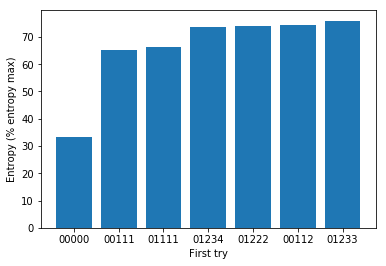

In [953]:
entropy_max= np.log(len(all_responses))
ft_std = {k: v for k, v in sorted(first_try.items(), key=lambda item: item[1])}
plt.bar(ft_std.keys(), np.array(list((ft_std.values())))*100 / entropy_max)
plt.xlabel("First try")
plt.ylabel("Entropy (% entropy max)")
plt.savefig("first_try_hist.png")
plt.show()

In [235]:
card =len(init_set_ar)

In [238]:
np.log(1/card)

-10.39720770839918

In [243]:
all_responses = [(i,j) for i in range(places+1) for j in range(places+1) if i+j<6]

In [252]:
optimum = card / len(all_responses)
entropy_max= np.log(len(all_responses))

In [266]:
np.array(list((ft_std.values())))*100 / entropy_max

array([33.40546903, 65.33389195, 66.48471284, 73.57285242, 73.92785062,
       74.35149671, 75.9444559 ])

In [376]:
def set_aft_resp(guess, response, set_list):
    responses = resp_list(guess, set_list)
    #expected result
    xptd_rep = np.repeat([response], len(responses), axis=0)
    # test equality, sum on axis, if == 2 exactcly the same then gets the arguments
    equality = (responses == xptd_rep)
    s = np.sum(equality, axis=1) 
    args = (s == 2)
    return set_list[args]
    
%timeit set_aft_resp(to_l("01234"), (0,5), init_set_ar)
%lprun -f set_aft_resp set_aft_resp(to_l("01234"), (0,5), init_set_ar)

70.2 ms ± 1.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [375]:
# actually not slow on this simple example
# sometimes looping is not so bad
def slow_aft_resp(guess, response, set_list):
    responses = resp_list(guess, set_list)
    res = []
    for i,rep in enumerate(responses):
        if rep == response:
            res.append(set_list[i])
    return res

%timeit slow_aft_resp(to_l("01234"), (0,5), init_set_ar)     
%lprun -f slow_aft_resp slow_aft_resp(to_l("01234"), (0,5), init_set_ar) 

64.6 ms ± 5.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [342]:
init_set_ar[np.argwhere(rep == np.array([0,5]))[:,0]]
init_set_ar[np.argwhere(rep == [0,5])[:,0]]

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 0, 2],
       ...,
       [7, 7, 7, 7, 5],
       [7, 7, 7, 7, 6],
       [7, 7, 7, 7, 7]])

In [ ]:
#expected result
xptd_rep = np.repeat([[0,5]], rep.shape[0], axis=0)
# test equality, sum on axis, if == 2 exactcly the same then gets the arguments
init_set_ar[(np.sum(rep == xptd_rep, axis=1) == 2)]

In [708]:
def play_bg_entropy(set_list, set_tries):
    res = {}
    for i in range(len(set_tries)):
        res[str(set_tries[i])] = round(entropy(set_tries[i], set_list),6)
    return res

def return_bg(set_list, set_tries):
    res = np.zeros(len(set_tries))
    for i in range(len(set_tries)):
        res[i] = round(entropy(set_tries[i], set_list),6)
    argmax = np.argwhere(res == res.max())[:,0]
    return(set_tries[argmax])
    

def play_random(g, try_list):
    poss = return_bg(g.set_list[g.cur_move], try_list)
    r = random.randint(0,len(poss)-1)
    print((poss))
    print(r)
    return poss[random.randint(0,len(poss)-1)]

In [709]:
r = set_aft_resp(to_l("01234"), (0,5), init_set_ar)
print(len(r))
print(g.cur_move)
print(g.set_list[-1])
play_random(g, r)
#%timeit res_test= play_bg_entropy_np(r, r)
#%timeit res_test= play_bg_entropy(r, r)

44
1
[[0 4 0 0 0]
 [0 4 0 0 4]
 [0 4 0 0 5]
 ...
 [7 7 7 1 3]
 [7 7 7 2 0]
 [7 7 7 2 1]]
[[1 4 0 2 3]
 [2 4 1 0 3]
 [3 4 1 2 0]
 [4 2 1 0 3]
 [4 3 1 2 0]]
3


array([3, 4, 1, 2, 0])

In [424]:
# There are 21 possible responses to the first try 
rr = np.vectorize(round)
res05 = rr(res05, 6)
res05.max()
r[res_test.argmax()]

array([1, 2, 3, 4, 0])

In [ ]:
init_set_ar[np.argwhere(res05 == res05.max())[:,0]]

In [423]:
Counter(resp_list([1, 2, 0, 0, 3], r))

Counter({(1, 3): 9,
         (2, 2): 2,
         (4, 1): 2,
         (2, 3): 8,
         (3, 2): 3,
         (0, 4): 11,
         (1, 4): 9})

In [435]:
np.array(list(Counter(resp_list([1, 2, 3, 4, 0],r)).values()))**2

array([ 25, 225,   1, 100, 169], dtype=int32)

In [440]:
# esperance from a distribution of responses
def esp(di):
    n = np.array(list(di.values()))
    return sum(n**2)/sum(n)

print(esp(Counter(resp_list([1, 2, 0, 0, 3], r))))
print(esp(Counter(resp_list([1, 2, 3, 4, 0],r))))

8.272727272727273
11.818181818181818


In [446]:
try_set = list(product(colour_list,repeat = places))

len(try_set)

3125

In [447]:
5**5

3125

In [734]:
def free_set(free_colors, set_list):
    if len(free_colors) <= 1:
        return set_list
    else:
        res_list = []
        for g in set_list: 
            g_res = []
            hash_res = {}
            nb_fc = 0
            for c in g:               
                if c in free_colors:
                    if c not in hash_res.keys():
                        nb_fc += 1
                        hash_res[c] = - nb_fc
                    g_res.append(hash_res[c])
                    
                else:
                    g_res.append(c)
            res_list.append(str(g_res).strip('[]'))
    # keep unique values
    res_set = set(res_list)
    # str to list 
    res_arr = np.array([[int(e) for e in s.split(',')] for s in string])
    for i, col in enumerate(free_colors):
        res_arr[res_arr == -i] = col
    return res_arr
                

In [737]:
fr = free_set([4,5,6,7], init_set)
#len(reduce(lambda l, x: l.append(x) or l if x not in l else l, fr, []))
print(len(fr))
print(len(init_set))

4735
32768


In [724]:
unique = []
for e in fr:
    if e not in unique:
        unique.append(e)

[int(e) for e in unique[0].strip('[]').split(',')]

[3, -1, -1, -2, 2]

In [712]:
len(unique)

4735

In [725]:
string = []
for e in fr:
    string.append(str(e).strip('[]'))

In [726]:
len(set(string))

4735

In [732]:
r = np.array([[int(e) for e in s.split(',')] for s in string])
r[r == -1] = 4

In [733]:
r

array([[ 3,  4,  4, -2,  2],
       [ 4,  0,  0,  4,  2],
       [ 4,  3,  0, -2,  0],
       ...,
       [ 4,  3,  3,  3,  1],
       [ 0,  3,  0,  4, -2],
       [ 1,  1,  4,  2,  4]])